# Transfer learning
in this notebook mobilenet is used to predict on CIFAR-10 dataset

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [18]:
import tensorflow as tf
import pickle
import numpy as np
import random
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from tensorflow import keras
from tensorflow.keras import models, layers, losses
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input

## 1.Loading dataset CIFAR-10

In [3]:
(X_train_full, y_train_full), (X_test, y_test) = cifar10.load_data()

## 2.Data preprocessing and augmentation

In [4]:
augmentation = keras.Sequential([
    keras.layers.RandomFlip("horizontal"),
    keras.layers.RandomRotation(0.15),
    keras.layers.RandomTranslation(0.1, 0.1),
    keras.layers.RandomZoom(0.1),
    keras.layers.RandomContrast(0.1),
])

def preprocessing(preprocessing_method, dataset, augment=True, target_size=(224, 224), shuffle=False, shuffle_buffer=1000):
    def _preprocess(image, label):
      image = tf.image.resize(image, target_size)
      if augment:
        image = augmentation(image)
      image = preprocessing_method(image)
      return image, label

    if shuffle:
      dataset = dataset.shuffle(buffer_size=shuffle_buffer)


    dataset = dataset.map(_preprocess, num_parallel_calls=tf.data.AUTOTUNE)
    return dataset

## 3.Train and test split, apply preprocessing, creating datasets
using batch size = 32

In [5]:
X_train, y_train = X_train_full[:-5000], y_train_full[:-5000]
X_val, y_val = X_train_full[-5000:], y_train_full[-5000:]

train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train))
val_ds = tf.data.Dataset.from_tensor_slices((X_val, y_val))
test_ds = tf.data.Dataset.from_tensor_slices((X_test, y_test))

train_ds_prep = preprocessing(preprocess_input, train_ds, augment=True, shuffle=True)
val_ds_prep = preprocessing(preprocess_input, val_ds, augment=False, shuffle=False)
test_ds_prep = preprocessing(preprocess_input, test_ds, augment=False, shuffle=False)

train_ds_prep = train_ds_prep.batch(32).prefetch(tf.data.AUTOTUNE)
val_ds_prep = val_ds_prep.batch(32).prefetch(tf.data.AUTOTUNE)
test_ds_prep = test_ds_prep.batch(32).prefetch(tf.data.AUTOTUNE)

print("data batchs shape:", next(iter(train_ds_prep))[0].shape)
print("target batchs shape:", next(iter(train_ds_prep))[1].shape)


data batchs shape: (32, 224, 224, 3)
target batchs shape: (32, 1)


## 4.Checking preprocess
getting min, Max of pixel values

In [6]:
min_val = float('inf')
max_val = float('-inf')

for images, _ in train_ds_prep.take(100):  # just check first 100 batches or full dataset
    batch_min = tf.reduce_min(images).numpy()
    batch_max = tf.reduce_max(images).numpy()
    if batch_min < min_val:
        min_val = batch_min
    if batch_max > max_val:
        max_val = batch_max

print("Min pixel value:", min_val)
print("Max pixel value:", max_val)

Min pixel value: -1.0
Max pixel value: 1.0


## 5.defining model structure with a base model

In [7]:
def _find_base_model(model):
    """Return the first layer of `model` that is a Keras Model (your base pretrained model)."""
    for layer in model.layers:
        if isinstance(layer, tf.keras.Model):
            return layer
    raise ValueError("No base model (sub-model) found in model.layers")

def set_unfreeze_last_n(model, n):
    """
    Make last `n` layers of the base model trainable, freeze the rest.
    Works in-place on the provided model.
    """
    base = _find_base_model(model)
    total = len(base.layers)
    n = max(0, min(n, total))  # clamp
    # freeze all first
    for layer in base.layers:
        layer.trainable = False
    # unfreeze last n
    if n > 0:
        for layer in base.layers[-n:]:
            layer.trainable = True
    print(f"[info] base_model layers: {total}, unfreezed last {n} layers.")

def build_model(base_model, num_classes=10, freeze_until=None):
  model = models.Sequential([
      base_model,
      layers.GlobalAveragePooling2D(),
      layers.Dense(128, activation='relu'),
      layers.Dropout(0.5),
      layers.Dense(num_classes, activation='softmax')
  ])
  return model


early_stop = keras.callbacks.EarlyStopping(
    monitor="val_loss",
    patience=7,
    restore_best_weights=True
)
lr_schedule = keras.callbacks.ReduceLROnPlateau(
    monitor="val_loss",
    patience=5,
    factor=0.5,
    verbose=1
)


## 6.Defining train_model function

In [8]:
def train_model(model, opt, train_ds, val_ds, epochs, init_epoch=0, loss="sparse_categorical_crossentropy", metric=['accuracy']):
  model.compile(
      loss=loss,
      optimizer=opt,
      metrics=metric
  )
  history = model.fit(
      train_ds,
      validation_data=val_ds,
      epochs=epochs,
      initial_epoch=init_epoch,
      callbacks=[early_stop, lr_schedule]
  )
  return model, history.history

## 7.Train model with mobilenet as base and all layers frozen

In [ ]:
base_model = MobileNetV2(input_shape=(224,224,3), include_top=False, weights='imagenet')
model = build_model(base_model)     # base frozen
optimizer = keras.optimizers.Nadam(learning_rate=1e-3)
model, history1 = train_model(model, optimizer, train_ds_prep, val_ds_prep, epochs=8)  # stage 1


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
Epoch 1/8
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 797s 524ms/step - accuracy: 0.5740 - loss: 1.3050 - val_accuracy: 0.3234 - val_loss: 5.5271 - learning_rate: 0.0010
Epoch 2/8
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 742s 502ms/step - accuracy: 0.7399 - loss: 0.8106 - val_accuracy: 0.3232 - val_loss: 4.8353 - learning_rate: 0.0010
Epoch 3/8
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 705s 501ms/step - accuracy: 0.7783 - loss: 0.6843 - val_accuracy: 0.2464 - val_loss: 7.1351 - learning_rate: 0.0010
Epoch 4/8
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 746s 504ms/step - accuracy: 0.7985 - loss: 0.6283 - val_accuracy: 0.5054 - val_loss: 2.8968 - learning_rate: 0.0010
Epoch 5/8
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 709s 504ms/step - accuracy: 0.8151 - loss: 0.5781 - val_accuracy: 0.7304 - val_loss: 1.1059 - learning_rate: 0.0010
Epoch 6/8
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 740s 503ms/step - accuracy: 0.8351 - loss: 0.5188 - val_accuracy: 0.6682 - val_loss: 1.3854 - learning_rate: 0.0010
Epoch 7/8

In [ ]:
with open("/content/drive/MyDrive/cifar10_project/results/mobilenet_first_training_step_history.pkl", "wb") as f:
    pickle.dump(history2, f)

## 8.Unfreeze 5 layers of base and lower LR

In [ ]:
set_unfreeze_last_n(model, 5)   # in-place change
opt_finetune = keras.optimizers.Nadam(learning_rate=1e-4)
model, history2 = train_model(model, opt_finetune, train_ds_prep, val_ds_prep, epochs=16, init_epoch=8)  # stage 2


[info] base_model layers: 154, unfreezed last 5 layers.
Epoch 9/16
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 657s 459ms/step - accuracy: 0.8082 - loss: 0.5924 - val_accuracy: 0.8520 - val_loss: 0.4191 - learning_rate: 1.0000e-04
Epoch 10/16
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 631s 449ms/step - accuracy: 0.8268 - loss: 0.5368 - val_accuracy: 0.8610 - val_loss: 0.3996 - learning_rate: 1.0000e-04
Epoch 11/16
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 689s 453ms/step - accuracy: 0.8308 - loss: 0.5109 - val_accuracy: 0.8640 - val_loss: 0.3910 - learning_rate: 1.0000e-04
Epoch 12/16
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 632s 449ms/step - accuracy: 0.8358 - loss: 0.5020 - val_accuracy: 0.8674 - val_loss: 0.3833 - learning_rate: 1.0000e-04
Epoch 13/16
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 683s 450ms/step - accuracy: 0.8354 - loss: 0.4992 - val_accuracy: 0.8714 - val_loss: 0.3729 - learning_rate: 1.0000e-04
Epoch 14/16
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 633s 450ms/step - accuracy: 0.8348 - loss: 0.4938 - val_accuracy: 0.8740 - val_loss: 0.

In [ ]:
with open("/content/drive/MyDrive/cifar10_project/results/mobilenet_second_training_step_history.pkl", "wb") as f:
    pickle.dump(history2, f)

## 9.Unfreeze 10 layers of base and lower LR

In [ ]:
set_unfreeze_last_n(model, 10)  # in-place change again
opt_finetune2 = keras.optimizers.Nadam(learning_rate=5e-5)
model, history3 = train_model(model, opt_finetune2, train_ds_prep, val_ds_prep, epochs=24, init_epoch=16)  # stage 3


[info] base_model layers: 154, unfreezed last 10 layers.
Epoch 17/24
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 718s 499ms/step - accuracy: 0.8423 - loss: 0.4808 - val_accuracy: 0.8814 - val_loss: 0.3560 - learning_rate: 5.0000e-05
Epoch 18/24
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 684s 486ms/step - accuracy: 0.8425 - loss: 0.4750 - val_accuracy: 0.8830 - val_loss: 0.3524 - learning_rate: 5.0000e-05
Epoch 19/24
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 748s 490ms/step - accuracy: 0.8472 - loss: 0.4712 - val_accuracy: 0.8856 - val_loss: 0.3498 - learning_rate: 5.0000e-05
Epoch 20/24
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 737s 487ms/step - accuracy: 0.8419 - loss: 0.4713 - val_accuracy: 0.8836 - val_loss: 0.3459 - learning_rate: 5.0000e-05
Epoch 21/24
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 745s 489ms/step - accuracy: 0.8432 - loss: 0.4702 - val_accuracy: 0.8860 - val_loss: 0.3435 - learning_rate: 5.0000e-05
Epoch 22/24
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 740s 488ms/step - accuracy: 0.8464 - loss: 0.4628 - val_accuracy: 0.8846 - val_loss: 

In [ ]:
model.save("/content/drive/MyDrive/cifar10_project/results/mobilenet_third_training_step_model_v1.keras")
with open("/content/drive/MyDrive/cifar10_project/results/mobilenet_third_training_step_history.pkl", "wb") as f:
    pickle.dump(history3, f)

In [9]:
# model = models.load_model("/content/drive/MyDrive/cifar10_project/results/mobilenet_third_training_step_model_v1.keras")

# with open("/content/drive/MyDrive/cifar10_project/results/mobilenet_first_training_step_history.pkl", "rb") as f:
#   history1 = pickle.load(f)

# with open("/content/drive/MyDrive/cifar10_project/results/mobilenet_second_training_step_history.pkl", "rb") as f:
#   history2 = pickle.load(f)

# with open("/content/drive/MyDrive/cifar10_project/results/mobilenet_third_training_step_history.pkl", "rb") as f:
#   history3 = pickle.load(f)


## 10.Concat histories function

In [10]:
def merge_histories(hist1, hist2, hist3):
    merged = {
        "accuracy": hist1["accuracy"] + hist2["accuracy"] + hist3["accuracy"],
        "val_accuracy": hist1["val_accuracy"] + hist2["val_accuracy"] + hist3["val_accuracy"],
        "loss": hist1["loss"] + hist2["loss"] + hist3["loss"],
        "val_loss": hist1["val_loss"] + hist2["val_loss"] + hist3["val_loss"]
    }
    return merged

## 11.Plot accuracy and loss for training and validation datasets

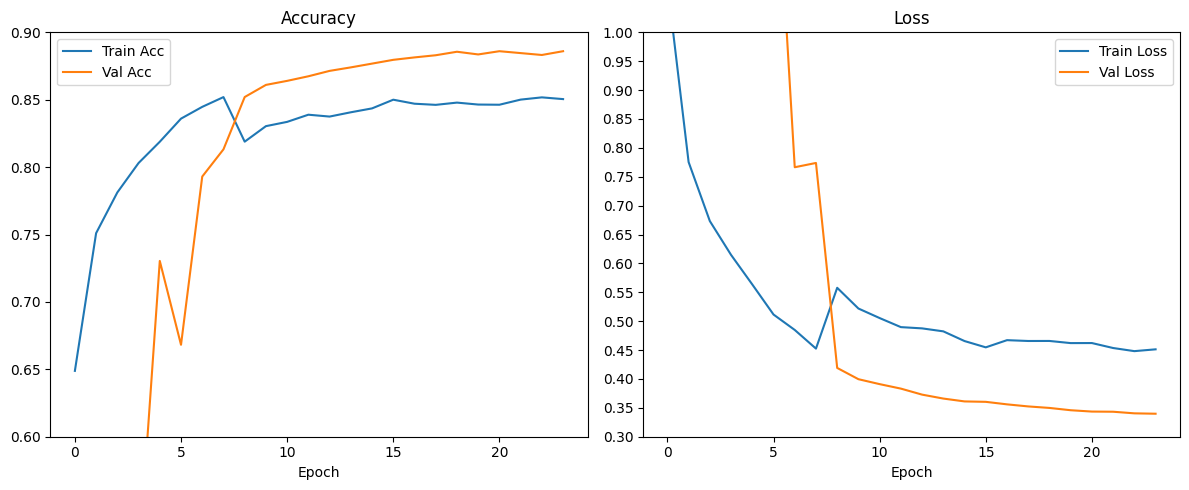

In [11]:
merged_history = merge_histories(history1, history2, history3)

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(merged_history["accuracy"], label="Train Acc")
plt.plot(merged_history["val_accuracy"], label="Val Acc")
plt.title("Accuracy")
plt.xlabel("Epoch")
plt.ylim(0.60, 0.9)
plt.yticks([i*0.05 for i in range(12, 19)])
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(merged_history["loss"], label="Train Loss")
plt.plot(merged_history["val_loss"], label="Val Loss")
plt.title("Loss")
plt.xlabel("Epoch")
plt.ylim(0.3, 1.0)
plt.yticks([i*0.05 for i in range(6, 21)])
plt.legend()

plt.tight_layout()
# plt.savefig("/content/drive/MyDrive/cifar10_project/results/mobilenet_accuracy_loss.png")
plt.show()

## 12.Evaluate test set

In [12]:
test_loss, test_acc = model.evaluate(test_ds_prep)
print(f"Test Accuracy: {test_acc:.4f}, Test Loss: {test_loss:.4f}")

313/313 ━━━━━━━━━━━━━━━━━━━━ 20s 39ms/step - accuracy: 0.8815 - loss: 0.3667
Test Accuracy: 0.8825, Test Loss: 0.3538


## 13.Confusion matrix

313/313 ━━━━━━━━━━━━━━━━━━━━ 9s 29ms/step


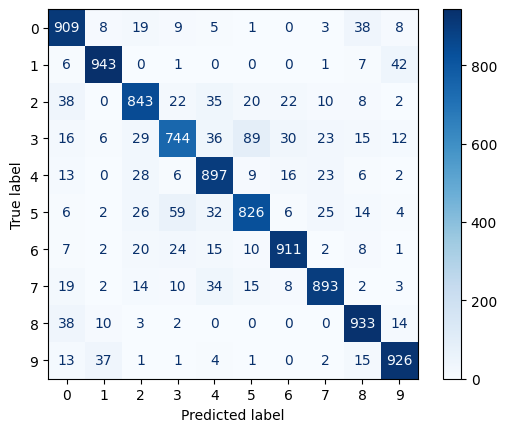

In [15]:
y_pred_probs = model.predict(test_ds_prep, verbose=1)

# Convert probabilities to class labels
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = y_test

# Generate confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix)
disp.plot(cmap='Blues')
plt.savefig("/content/drive/MyDrive/cifar10_project/results/mobilenet_confusion_matrix.png")
plt.show()

## 14.Report model results and scores

In [16]:
print(classification_report(y_true, y_pred, digits=4))

              precision    recall  f1-score   support

           0     0.8535    0.9090    0.8804      1000
           1     0.9337    0.9430    0.9383      1000
           2     0.8576    0.8430    0.8502      1000
           3     0.8474    0.7440    0.7923      1000
           4     0.8478    0.8970    0.8717      1000
           5     0.8507    0.8260    0.8382      1000
           6     0.9174    0.9110    0.9142      1000
           7     0.9094    0.8930    0.9011      1000
           8     0.8920    0.9330    0.9120      1000
           9     0.9132    0.9260    0.9196      1000

    accuracy                         0.8825     10000
   macro avg     0.8823    0.8825    0.8818     10000
weighted avg     0.8823    0.8825    0.8818     10000



## 15.Desplay some predictions

/tmp/ipython-input-27496549.py:9: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  true_label = class_names[int(y_true[idx])]


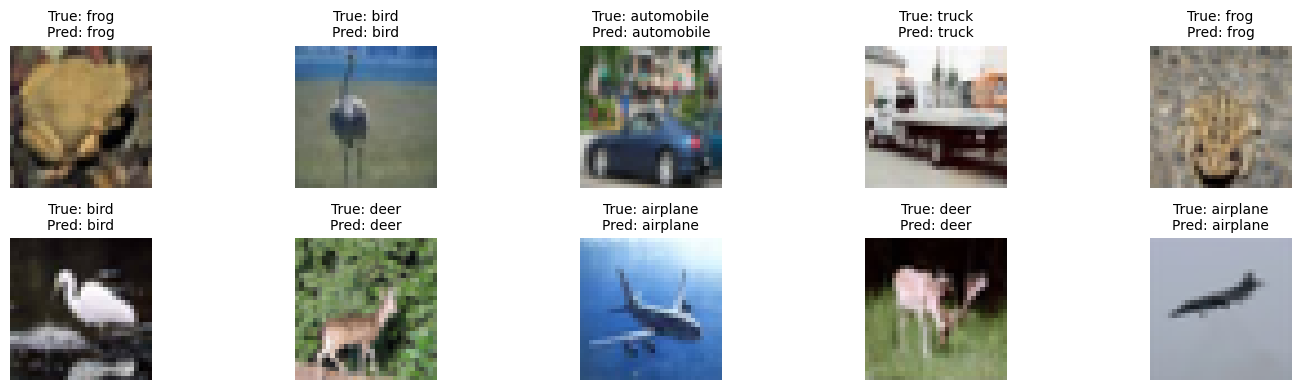

In [20]:
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

indices = random.sample(range(len(X_test)), 10)
plt.figure(figsize=(15, 4))

for i, idx in enumerate(indices):
    img = X_test[idx]
    true_label = class_names[int(y_true[idx])]
    pred_label = class_names[int(y_pred[idx])]

    plt.subplot(2, 5, i + 1)
    plt.imshow(img)
    plt.title(f"True: {true_label}\nPred: {pred_label}", fontsize=10)
    plt.axis("off")

plt.tight_layout()
plt.show()